# Data and data split

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from ISLP import load_data

from Classification.Breast_Cancer import result

data = load_data('Wage')
data

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...
2995,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
2996,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
2997,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
2998,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


b## Data split

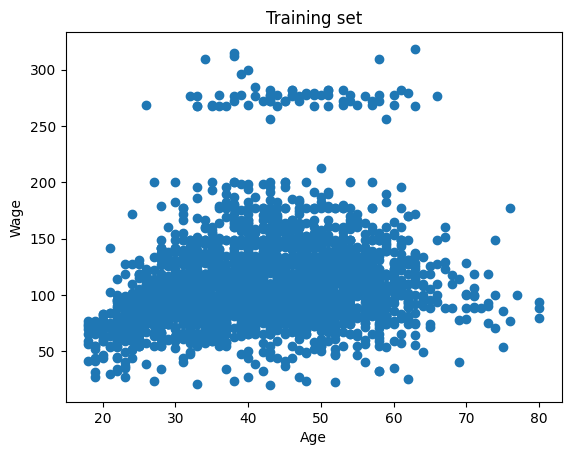

In [81]:
from sklearn.model_selection import train_test_split


X, y = data[['age']], data[['wage']]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.scatter(x_train, y_train)
plt.xlabel('Age')
plt.ylabel('Wage')
plt.title("Training set")
plt.show()

# Metric and plot function

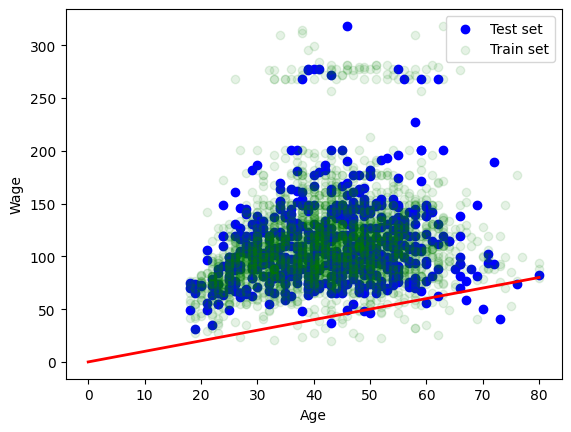

,MSE,RMSE,R2
0,0.0,0.0,1.0


In [82]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

def metric(y_hat, y_true):
    score = pd.DataFrame({
        'MSE': [mean_squared_error(y_true, y_hat)],
        'RMSE':[np.sqrt(mean_squared_error(y_true, y_hat))],
        'R2': [r2_score(y_true, y_hat)],
    })


    return score


def plot(coefs):
    global y_train, y_test

    polynomial = np.poly1d(coefs)
    x = np.linspace(0, 80, 400)
    y = polynomial(x)

    plt.plot(x, y, color='red', linewidth=2)
    plt.scatter(x_test, y_test, color='blue', label='Test set')
    plt.scatter(x_train, y_train, color='green', label='Train set', alpha=0.1)
    plt.xlabel('Age')
    plt.ylabel('Wage')
    plt.legend()
    plt.show()



plot([1,0])
metric(y_train, y_train)

# Polynomial Regression


In [83]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


pipeline = Pipeline([('poly', PolynomialFeatures(degree=2)), ('regressor', LinearRegression())])

pipeline

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('regressor', LinearRegression())])

## Optimal degree of polynomial  - MSE Minimalization

In [84]:
import optuna
from sklearn.model_selection import cross_val_score


def object_poly(trial):
    global x_train, x_test
    degree = trial.suggest_int('poly__degree', 1, 20)
    pipeline = Pipeline([('poly', PolynomialFeatures(degree=degree)), ('regressor', LinearRegression(fit_intercept=False))])
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(pipeline, x_train, y_train, cv=cv, scoring= 'neg_mean_squared_error').mean()

    return score

study = optuna.create_study(direction="maximize")
study.optimize(object_poly, n_trials=20, show_progress_bar=True)
print(study.best_params)


pipeline.set_params(**study.best_params)
pipeline.fit(x_train, y_train)

poly_score = metric(pipeline.predict(x_test), y_test)
poly_score

[I 2025-12-08 12:30:10,098] A new study created in memory with name: no-name-522e7559-badf-4449-a903-4559e88db215


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-08 12:30:10,151] Trial 0 finished with value: -1684.601780743114 and parameters: {'poly__degree': 12}. Best is trial 0 with value: -1684.601780743114.
[I 2025-12-08 12:30:10,232] Trial 1 finished with value: -4175.527945391521 and parameters: {'poly__degree': 17}. Best is trial 0 with value: -1684.601780743114.
[I 2025-12-08 12:30:10,304] Trial 2 finished with value: -2592.8406540493816 and parameters: {'poly__degree': 14}. Best is trial 0 with value: -1684.601780743114.
[I 2025-12-08 12:30:10,362] Trial 3 finished with value: -2592.8406540493816 and parameters: {'poly__degree': 14}. Best is trial 0 with value: -1684.601780743114.
[I 2025-12-08 12:30:10,393] Trial 4 finished with value: -1719.3036334882886 and parameters: {'poly__degree': 1}. Best is trial 0 with value: -1684.601780743114.
[I 2025-12-08 12:30:10,419] Trial 5 finished with value: -1637.9448065283925 and parameters: {'poly__degree': 3}. Best is trial 5 with value: -1637.9448065283925.
[I 2025-12-08 12:30:10,44

,MSE,RMSE,R2
0,1436.132781,37.896343,0.078822


## Ploting

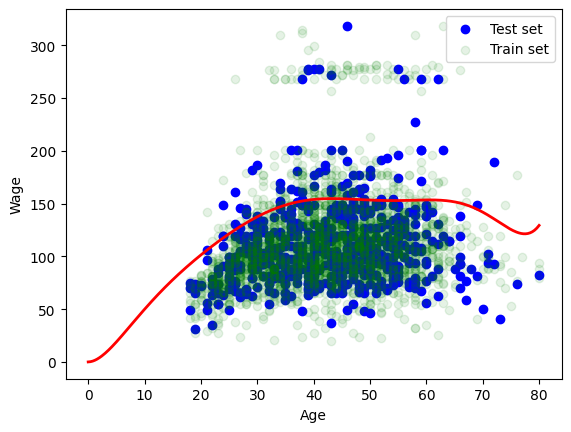

[ 5.34381844e-11 -1.62538785e-08  2.00943424e-06 -1.30397417e-04
  4.81005141e-03 -1.02513430e-01  1.14497236e+00  9.95239167e-02
  0.00000000e+00]


In [85]:
linear_model = pipeline.named_steps['regressor']
coefficients = linear_model.coef_.ravel()[::-1]

plot(coefficients)
print(coefficients)

### ANOVA


In [93]:
from scipy.stats import f

def calculate_rss(model, X, y):
    y_pred = model.predict(X)
    return np.sum((y - y_pred)**2)



result = pd.DataFrame({
    "Polynomial Degrees": [],
    "F - statistic": [],
    'p-value': [],
})


max_degree = 10
for d in range(2, max_degree + 1):
    poly_d = PolynomialFeatures(degree=d, include_bias=False)
    X_d = poly_d.fit_transform(X)
    model_d = LinearRegression().fit(X_d, y)
    RSS_d = calculate_rss(model_d, X_d, y)




TRAIN: [   0    1    2 ... 2394 2396 2399]
TEST: [  18   25   29   43   44   48   49   51   56   67   69   70   73   76
   84   96  100  109  111  118  124  128  134  135  149  157  168  173
  174  177  178  179  184  188  192  196  199  203  208  210  211  212
  218  219  220  229  231  233  237  239  240  247  251  252  254  259
  279  281  282  289  290  291  296  298  299  303  307  321  324  332
  342  350  353  354  361  366  367  368  383  387  402  407  408  410
  414  416  420  422  426  430  432  433  435  438  440  443  445  450
  461  463  464  471  472  478  479  480  482  485  486  495  507  508
  509  518  522  527  528  530  532  544  554  555  564  565  575  581
  602  605  610  611  613  617  618  621  629  632  637  642  643  649
  650  651  654  668  672  677  679  685  694  707  719  729  733  736
  742  744  756  759  764  767  781  782  785  786  787  788  790  798
  800  809  810  819  821  831  834  838  840  855  856  857  859  861
  869  873  874  881  886  8